## Detección de fraudes por llenado de piscinas con imágenes del satélite Sentinel 2

José María de Cuenca

Parto de una descarga de 6 escenas satelitales con 12 imágenes por escena, una para cada una de sus bandas espectrales, más una imagen multiespectral por escena:
- band1  - Aerosol costero, 0.43-0.45 (60m)
- band2  - Azul, 0.45-0.52 (10m)
- band3  - Verde, 0.54-0.57 (10m)
- band4  - Rojo, 0.65-0.68 (10m)
- band5  - Borde rojo 1, 0,69-0,71 (20m)
- band6  - Borde rojo 2, 0,73-0,74 (20m)
- band7  - Borde rojo 3, 0,77-0,79 (20m)
- band8  - Infrarrojo cercano (NIR) 1, 0,78-0,90 (10m)
- band8A - Infrarrojo cercano (NIR) 2, 0,85-0,87 (20m)
- band9  - Vapor de agua, 0,93-0,95 (60m)
- band10 - SWIR Cirrus, 1,37-1,38 (60m)
- band11 - Infrarrojo de onda corta (SWIR) 1, 1,59-1,65 (20m)
- band12 - Infrarrojo de onda corta (SWIR) 2, 2,10-2,28 (20m)
- bandRGB - Composicion RGB

Las imágenes originales han sido previamente preprocesadas: se ha recortado el área de interés con la librería GDAL de OSGEO, y el archivo poligonal del término municipal de Valladolid en formato shapefile de GIS.

Además he reescalado las bandas del rojo cercano y el infrarrojo para pasar su resolución de 20 a 10m por pixel, y poder procesarlas de manera homogénea junto con el resto de bandas en el espectro visible. Para ello se han cargado como objetos rasterio y aplicado el método de reescalado de asignación de valor mediante el vecino más cercano de la librería de isión artificial OpenCV. Se descartan las bandas 1, 9 y 10 por su muy inferior resolución.

El resultado de este proceso previo son las imágenes que se utilizarán como datos de partida en este cuaderno.

### Extraccion de informacion puntual de los raster

Uso un bucle para automatizar la extracción de todas las imágenes. Creo un dataframe para cada escena por separado, porque en cada una se etiqueta el estado de lleno o vacío de las piscinas en ese momento, y es independiente de su situación en otra escena. Guardo ese conjunto de datos como un archivo csv.

In [1]:
# Cargo librerías y funciones
import time
import os

import numpy as np
import pandas as pd

import geopandas as gpd
import rasterio
from rasterio.plot import show

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import graphviz 

import matplotlib.pyplot as plt
%matplotlib inline

Sistema de proyeccion shapefile:  epsg:32630


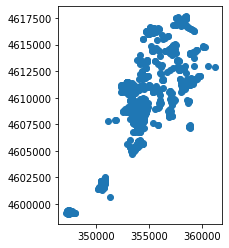

In [2]:
# Cargo el shapefile de puntos con las ubicaciones de las piscinas como un objeto GeoDataFrame
pointData = gpd.read_file('./Piscinas_shp/Pisci_pt.shp')

# Muestro su sistema de proyeccion y contenido
print('Sistema de proyeccion shapefile: ', pointData.crs)
pointData.plot()

In [3]:
# Defino variables de entorno para carga de imágenes ya recortadas
inputPath = './Sentinel2 - VA/'

# Defino lista con los nombres para cada archivo, tomando los de extensión tif.
# Pero no incorporo las imágenes multiespectrales en RGB, solo las monoespectrales
bandList = [band for band in os.listdir(inputPath) if band[-4:]=='.tif' and band[9:10]=='B']

# Muestro la lista
bandList 

['20200206_B02.tif',
 '20200206_B03.tif',
 '20200206_B04.tif',
 '20200206_B05.tif',
 '20200206_B06.tif',
 '20200206_B07.tif',
 '20200206_B08.tif',
 '20200206_B08A.tif',
 '20200206_B11.tif',
 '20200206_B12.tif',
 '20200327_B02.tif',
 '20200327_B03.tif',
 '20200327_B04.tif',
 '20200327_B05.tif',
 '20200327_B06.tif',
 '20200327_B07.tif',
 '20200327_B08.tif',
 '20200327_B08A.tif',
 '20200327_B11.tif',
 '20200327_B12.tif',
 '20200605_B02.tif',
 '20200605_B03.tif',
 '20200605_B04.tif',
 '20200605_B05.tif',
 '20200605_B06.tif',
 '20200605_B07.tif',
 '20200605_B08.tif',
 '20200605_B08A.tif',
 '20200605_B11.tif',
 '20200605_B12.tif',
 '20200710_B02.tif',
 '20200710_B03.tif',
 '20200710_B04.tif',
 '20200710_B05.tif',
 '20200710_B06.tif',
 '20200710_B07.tif',
 '20200710_B08.tif',
 '20200710_B08A.tif',
 '20200710_B11.tif',
 '20200710_B12.tif',
 '20200819_B02.tif',
 '20200819_B03.tif',
 '20200819_B04.tif',
 '20200819_B05.tif',
 '20200819_B06.tif',
 '20200819_B07.tif',
 '20200819_B08.tif',
 '2020081

In [4]:
print("Número de archivos: ", len(bandList))

# Obtengo lista con nombres de escena, como valores unicos de la lista de bandas

bases=[] # Creo lista vacia para almacenar temporalmente los nombres

for band in bandList:
    bases.append(band[0:8])
    
escenas = set(bases)

print("Número de escenas: ", len(escenas))

print("Escenas: ", escenas) # Muestro valores unicos de las etiquetas

# Debo convertir el objeto SET (escenas) en una lista para poder accederle, y que sea suscriptable
lista_escenas = list(escenas)

# Ordeno la lista de escenas
lista_escenas.sort()

# La muestro
print("Lista escenas ordenada:\n", lista_escenas)

Número de archivos:  60
Número de escenas:  6
Escenas:  {'20200327', '20200206', '20200710', '20200928', '20200819', '20200605'}
Lista escenas ordenada:
 ['20200206', '20200327', '20200605', '20200710', '20200819', '20200928']


In [5]:
## Recorro el conjunto de escenas, obteniendo la imagen (banda) de cada una,
## y extraigo los valores de todos los puntos marcados por el shp

# Creo otra lista con los nombres de las bandas para componer la llamada a las imágenes de cada escena
list_imag = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B08A', 'B11', 'B12' ]

for escena in lista_escenas:
    # Preparo un dataframe normal a partir del geodataframe y elimino la columna de geometría
    # Aún así se mantienen los campos X e Y de coordenadas
    escena_pd = pd.DataFrame(pointData.drop(columns='geometry'))
    
    # Recorro todas las imagenes de esa escena
    for imag in list_imag:
        # Compongo la ruta de la imagen
        imagen = str('./Sentinel2 - VA/'+ escena + '_' + imag + '.tif')
        # Muestro la imagen que se procesa
        print(imagen)

        # Cargo la imagen geotiff
        ndviRaster = rasterio.open(imagen)

        # Creo una lista vacia para los valores
        val_pt_raster = []

        # Extraigo el valor de cada punto del shp desde el rasterio
        for point in pointData['geometry']:
            # Tomo las coordenadas de cada objeto del GeoDataFrame
            x = point.xy[0][0]
            y = point.xy[1][0]
            # Obtengo el pixel al que se corresponden esas coordenadas
        
            # OJO, tienen qyue tener el mismo sistema de proyección CRS
            row, col = ndviRaster.index(x,y)
    
            # Obtengo el valor de ese punto del geotiff a la lista
            val_pt_raster.append(ndviRaster.read(1)[row,col])
    
        # Añado los valores de la lista para esta banda en una nueva columna del pandas dataframe
        escena_pd[imag] = val_pt_raster

    # Persisto el dataframe de la escena como un csv
    # No guardo el indice del pandas porque el shape de partida ya tenia una columna id con él
    escena_pd.to_csv('./DataRaster_csv/'+ escena +'.csv', index = False)
    # Muestro el resultado. Requiere print porque esta dentro de bucle con otros mensajes
    print(escena_pd.head())
    # Vemos que se muestra una columna de indice ['unnamed 0'] pero no se guardará en los csv


./Sentinel2 - VA/20200206_B02.tif
./Sentinel2 - VA/20200206_B03.tif
./Sentinel2 - VA/20200206_B04.tif
./Sentinel2 - VA/20200206_B05.tif
./Sentinel2 - VA/20200206_B06.tif
./Sentinel2 - VA/20200206_B07.tif
./Sentinel2 - VA/20200206_B08.tif
./Sentinel2 - VA/20200206_B08A.tif
./Sentinel2 - VA/20200206_B11.tif
./Sentinel2 - VA/20200206_B12.tif
   id    Area           X            Y 20200206 20200327 20200605 20200710  \
0   0  463.59  353881.409  4610595.718    VACIA    VACIA    VACIA    LLENA   
1   1  316.48  353948.210  4610822.406    VACIA    VACIA    VACIA    LLENA   
2   2   53.30  353934.862  4610798.209    VACIA    VACIA    VACIA    LLENA   
3   3   20.45  353996.573  4610739.601    VACIA    VACIA    VACIA    LLENA   
4   4  100.10  354008.938  4610731.489    VACIA    VACIA    LLENA    LLENA   

  20200819 20200928   B02   B03   B04   B05   B06   B07   B08  B08A   B11  \
0    LLENA    VACIA  1672  2024  1564  1931  2640  2877  3084  2900  2378   
1    LLENA    VACIA   843  1248  104

Se guardan los datos en csv para facilitar la reutilización del código si se desean incorporar nuevas escenas y/o datos adicionales.

### Creo un algoritmo de clasificación mediante un árbol de decisión

Para ello en primer lugar creo un dataframe conjunto con los extraídos de cada escena. Y filtro aquellos datos que contienen la suficiente información para que trabaje el algoritmo: piscinas de gran superficie, que no estén abandonadas ni cubiertas.

Igualmente para facilitar la reutilización se procesan las escenas manualmente, sin una lista o bucle que reduzca el código.

In [6]:
# Creo un banco de datos completo manipulando columnas de todos los csv's

# Cargo primer dataset
bankdata_1 = pd.read_csv('./DataRaster_csv/20200206.csv')

# Creo un identificador único en columna adicional
bankdata_1['id_img'] = bankdata_1['id'].apply(str) + '_20200206'

# Renombro su columna de etiquetas
bankdata_1.rename(columns={'20200206':'Estado'}, inplace=True)

# Elimino el resto de etiquetas, corresponientes a otras escenas
bankdata_1.drop(['20200327', '20200605', '20200710', '20200819', '20200928'], axis=1, inplace=True)


# Cargo el segundo dataset
bankdata_2 = pd.read_csv('./DataRaster_csv/20200327.csv')

# Creo un identificador único en columna adicional
bankdata_2['id_img'] = bankdata_2['id'].apply(str) + '_20200327'

# Renombro su columna de etiquetas
bankdata_2.rename(columns={'20200327':'Estado'}, inplace=True)

# Elimino el resto de etiquetas, corresponientes a otras escenas
bankdata_2.drop(['20200206', '20200605', '20200710', '20200819', '20200928'], axis=1, inplace=True)


# Cargo el tecer dataset
bankdata_3 = pd.read_csv('./DataRaster_csv/20200605.csv')

# Creo un identificador único en columna adicional
bankdata_3['id_img'] = bankdata_3['id'].apply(str) + '_20200605'

# Renombro su columna de etiquetas
bankdata_3.rename(columns={'20200605':'Estado'}, inplace=True)

# Elimino el resto de etiquetas, corresponientes a otras escenas
bankdata_3.drop(['20200206', '20200327', '20200710', '20200819', '20200928'], axis=1, inplace=True)


# Cargo el cuarto dataset
bankdata_4 = pd.read_csv('./DataRaster_csv/20200710.csv')

# Creo un identificador único en columna adicional
bankdata_4['id_img'] = bankdata_4['id'].apply(str) + '_20200710'

# Renombro su columna de etiquetas
bankdata_4.rename(columns={'20200710':'Estado'}, inplace=True)

# Elimino el resto de etiquetas, corresponientes a otras escenas
bankdata_4.drop(['20200206', '20200327', '20200605', '20200819', '20200928'], axis=1, inplace=True)


# Cargo el quinto dataset
bankdata_5 = pd.read_csv('./DataRaster_csv/20200819.csv')

# Creo un identificador único en columna adicional
bankdata_5['id_img'] = bankdata_5['id'].apply(str) + '_20200819'

# Renombro su columna de etiquetas
bankdata_5.rename(columns={'20200819':'Estado'}, inplace=True)

# Elimino el resto de etiquetas, corresponientes a otras escenas
bankdata_5.drop(['20200206', '20200327', '20200605', '20200710', '20200928'], axis=1, inplace=True)


# Cargo el sexto dataset
bankdata_6 = pd.read_csv('./DataRaster_csv/20200928.csv')

# Creo un identificador único en columna adicional
bankdata_6['id_img'] = bankdata_6['id'].apply(str) + '_20200928'

# Renombro su columna de etiquetas
bankdata_6.rename(columns={'20200928':'Estado'}, inplace=True)

# Elimino el resto de etiquetas, corresponientes a otras escenas
bankdata_6.drop(['20200206', '20200327', '20200605', '20200710', '20200819'], axis=1, inplace=True)


# Uno estos dataset ignorando sus indices individuales
# Esto genera un indice nuevo para el conjunto de datos agrupados
# Pero se mantiene la columna id que identifica cada piscina, y era el índice del shape
bankdata_all = pd.concat([bankdata_1, bankdata_2, bankdata_3, bankdata_4, bankdata_5, bankdata_6], ignore_index = True)


# Inspecciona datos
print ("Forma dataset: ", bankdata_all.shape)
# Visualiza cabecera
print ("\nMuestra de datos:\n")
bankdata_all.head()

Forma dataset:  (5046, 16)

Muestra de datos:



,id,Area,X,Y,Estado,B02,B03,B04,B05,B06,B07,B08,B08A,B11,B12,id_img
0,0,463.59,353881.409,4610595.718,VACIA,1672,2024,1564,1931,2640,2877,3084,2900,2378,1922,0_20200206
1,1,316.48,353948.210,4610822.406,VACIA,843,1248,1042,1527,2077,2359,2866,2326,1880,1435,1_20200206
2,2,53.30,353934.862,4610798.209,VACIA,631,966,955,1108,1642,1644,2316,1808,1394,957,2_20200206
3,3,20.45,353996.573,4610739.601,VACIA,348,609,598,1062,1790,1793,2424,1983,1545,1166,3_20200206
4,4,100.10,354008.938,4610731.489,VACIA,1040,1086,1062,1239,1839,2228,2412,2386,1788,1271,4_20200206


In [7]:
# Persisto el dataframe de todos los datos como csv
bankdata_all.to_csv('./DataRaster_csv/bankdata_all.csv')

In [8]:
# Hago una copia completa y desvinculada para manipular
bankdata = bankdata_all.copy(deep = True)

In [9]:
## PREPROCESADO sobre la copia

# Elimino las piscinas de menor superficie, que no dan una precisión suficiente 
# por la resolución de las imagenes utilizadas (20m pixel)
bankdata = bankdata.drop(bankdata[bankdata['Area']<50].index)

# Elimino las piscinas abandonadas y cubiertas
bankdata = bankdata.drop(bankdata[bankdata['Estado']=='ABANDONADA'].index)
bankdata = bankdata.drop(bankdata[bankdata['Estado']=='CUBIERTA'].index)

# Reseteo el indice del dataframe para facilitar su procesado posterior
# Con drop evito que el anterior pase a una nueva columna
# Con inplace evito crear un nuevo objeto
bankdata.reset_index(drop = True, inplace = True)

# Muestro los datos que se usarán
print ("Forma dataset: ", bankdata.shape)
# Visualiza cabecera
print ("\nMuestra de datos:\n")
bankdata.head()

Forma dataset:  (1800, 16)

Muestra de datos:



,id,Area,X,Y,Estado,B02,B03,B04,B05,B06,B07,B08,B08A,B11,B12,id_img
0,0,463.59,353881.409,4610595.718,VACIA,1672,2024,1564,1931,2640,2877,3084,2900,2378,1922,0_20200206
1,1,316.48,353948.210,4610822.406,VACIA,843,1248,1042,1527,2077,2359,2866,2326,1880,1435,1_20200206
2,2,53.30,353934.862,4610798.209,VACIA,631,966,955,1108,1642,1644,2316,1808,1394,957,2_20200206
3,4,100.10,354008.938,4610731.489,VACIA,1040,1086,1062,1239,1839,2228,2412,2386,1788,1271,4_20200206
4,5,77.66,353995.819,4610709.517,VACIA,738,1064,1386,1282,1887,1989,2258,2107,2251,1789,5_20200206


In [10]:
# Persisto el dataframe de los datos adecuados como csv
bankdata.to_csv('./DataRaster_csv/bankdata_reducido.csv')

In [11]:
# Divide los datos en atributos y etiquetas
X = bankdata.drop(['Estado'], axis=1)
y = bankdata['Estado']

X.head()

,id,Area,X,Y,B02,B03,B04,B05,B06,B07,B08,B08A,B11,B12,id_img
0,0,463.59,353881.409,4610595.718,1672,2024,1564,1931,2640,2877,3084,2900,2378,1922,0_20200206
1,1,316.48,353948.210,4610822.406,843,1248,1042,1527,2077,2359,2866,2326,1880,1435,1_20200206
2,2,53.30,353934.862,4610798.209,631,966,955,1108,1642,1644,2316,1808,1394,957,2_20200206
3,4,100.10,354008.938,4610731.489,1040,1086,1062,1239,1839,2228,2412,2386,1788,1271,4_20200206
4,5,77.66,353995.819,4610709.517,738,1064,1386,1282,1887,1989,2258,2107,2251,1789,5_20200206


In [12]:
y.head()

0    VACIA
1    VACIA
2    VACIA
3    VACIA
4    VACIA
Name: Estado, dtype: object

In [13]:
# Crea dataset de entrenamiento y pruebas

# Estratifico el resultado para que haya la misma proporcion de valores cada etiqueta en la clasificacion
# Es necesario para que el conjunto de test sea significativo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=7, stratify = y)

print("Datos de entrenamiento: ", X_train.shape)
print("Datos de prueba: ", X_test.shape)

Datos de entrenamiento:  (1440, 15)
Datos de prueba:  (360, 15)


In [14]:
# Creo un dataframe auxiliar para guardar los resultados
# Lo podré usar para posteriormente analizar los fallos y aciertos en GIS, cargandolo con sus coordenadas
# Igualmente para localizar los infractores, si uso como conjunto de test datos nuevos a clasificar una vez entrenado el modelo.

# Para ello uno el conjunto de datos de test con el de etiquetas
Xy_test = X_test.join(y_test)

print('Dimensiones Xy_test: ', Xy_test.shape)
Xy_test.head()

Dimensiones Xy_test:  (360, 16)


,id,Area,X,Y,B02,B03,B04,B05,B06,B07,B08,B08A,B11,B12,id_img,Estado
1760,696,374.42,357972.204,4611504.214,2460,1781,1601,1795,2807,3470,2483,3419,2051,1277,696_20200928,VACIA
1404,569,95.69,353800.092,4608955.278,1469,1404,1254,2014,2580,2857,3091,3033,2941,2350,569_20200819,LLENA
493,540,93.94,354413.460,4607785.128,1380,1154,1208,1637,2171,2593,2743,2437,2344,1965,540_20200327,VACIA
414,304,72.47,354165.843,4607527.985,933,1198,1212,1753,2669,3196,3614,3229,2459,1660,304_20200327,VACIA
199,558,109.20,353605.515,4608787.719,1580,1282,1292,1402,1975,2066,2104,2253,1585,1201,558_20200206,VACIA


### Modelo de árbol de decisión simple

In [15]:
# Entreno un clasificador ARBOL DE DECISION

# Inicia cronometro
start_time = time.time()

# Defino un modelo ARBOL DE DECISION
clf_AD = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth=10, min_samples_split=3)

# Modelo de entrenamiento
clf_AD = clf_AD.fit(X_train, y_train)

# Detiene el cronometro
end_time = time.time()

# Informo cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del ARBOL DE DECISION ha tardado: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# Pruebo el modelo con el conjunto de datos de prueba
y_pred = clf_AD.predict(X_test)

# Obtengo metricas
print('\nPrecision general de las predicciones con Arbol de Decision')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, y_pred)))

print("\nMatriz de confusion para el conjunto de prueba:")
print(confusion_matrix(y_test, y_pred))


# Informo de rendimiento sobre el conjunto de prueba
print("\nInforme de rendimiento para el conjunto de prueba:")
print(classification_report(y_test, y_pred))

print('Precisión modelo conjunto train: ', round(clf_AD.score(X_train, y_train), 3))
print('Precisión modelo conjunto test: ', round(clf_AD.score(X_test, y_test),3))


El entrenamiento del ARBOL DE DECISION ha tardado:  0.04 segundos ( 0.0 minutos)

Precision general de las predicciones con Arbol de Decision
75.83%


Matriz de confusion para el conjunto de prueba:
[[116  44]
 [ 43 157]]

Informe de rendimiento para el conjunto de prueba:
              precision    recall  f1-score   support

       LLENA       0.73      0.72      0.73       160
       VACIA       0.78      0.79      0.78       200

    accuracy                           0.76       360
   macro avg       0.76      0.76      0.76       360
weighted avg       0.76      0.76      0.76       360

Precisión modelo conjunto train:  0.928
Precisión modelo conjunto test:  0.758


### Interpretación de métricas:

#### Matriz de confusión: 
Es la métrica para algoritmos de clasificación que cruza aciertos y fallos. La diagonal principal recoge las probabilidades de acierto real.

Nº de casos m	| Predicho = 0	| Predicho = 1
:-------------: |               | --------------
Real = 0	| TN Verdaderos negativos|   FP Falsos positivos
Real = 1	|   FN Falsos negativos	 | TP Verdaderos positivos

La precisión es la media de las probabilidades recogidas en la diagonal principal. Además, de la matriz:
- Total real de positivos: es la suma de la fila 2: falsos negativos y verdaderos positivos.
- Total predicho de positivos: es la suma de la columna 2: falsos positivos y verdaderos positivos

#### Reporte de precisión y recuperación:

- Precisión (precision): métrica para algoritmos de clasificación que mide la relación entre aciertos positivos y total de positivos predicho. Probabilidad de acertar positivos. Mide las predicciones correctas. COLUMNA 2 - POSITIVOS.

precisión (precision)=TP/(FP+TP)=(Nº Verdaderos positivos)/(Nº falsos positivos+Nº verdaderos positivos)

- Recuperación (recall) exactitud o probabilidad de la clase positiva: métrica para algoritmos de clasificación que mide la relación de aciertos positivos que se han clasificado correctamente. Indica la robustez. FILA 2.

recuperación (recall)=TP/(FN+TP)=(Nº Verdaderos positivos)/(Nº falsos negativos+Nº verdaderos positivos)

- F1 Score: media armónica entre precisión y recall, da un valor entre 0 y 1 que mide como de preciso es el clasificador (cuantos casos clasifica correctamente) y como es de robusto (no falla en los positivos).

F1=2 1/(1/precisión+1/recall)=(2∙recall∙precision)/(recall+precision)

- Support es el númeoro de muestras de la respuesta verdadera que se encuentran en esa clase.

El objetivo de un algoritmo debe ser maximizar la exactitud de la clase positiva (recall) sin sacrificar dar como positivos aquellos que no lo son (precision).

Su grado de precisión se representa por la exactitud general del modelo (accuracy).


#### Creo el diagrama de árbol de decision

Lo visualizo en pantalla y lo guardo como pdf. Requiere tener la librería graphviz instalada. En caso contrario, se puede obviar este paso:

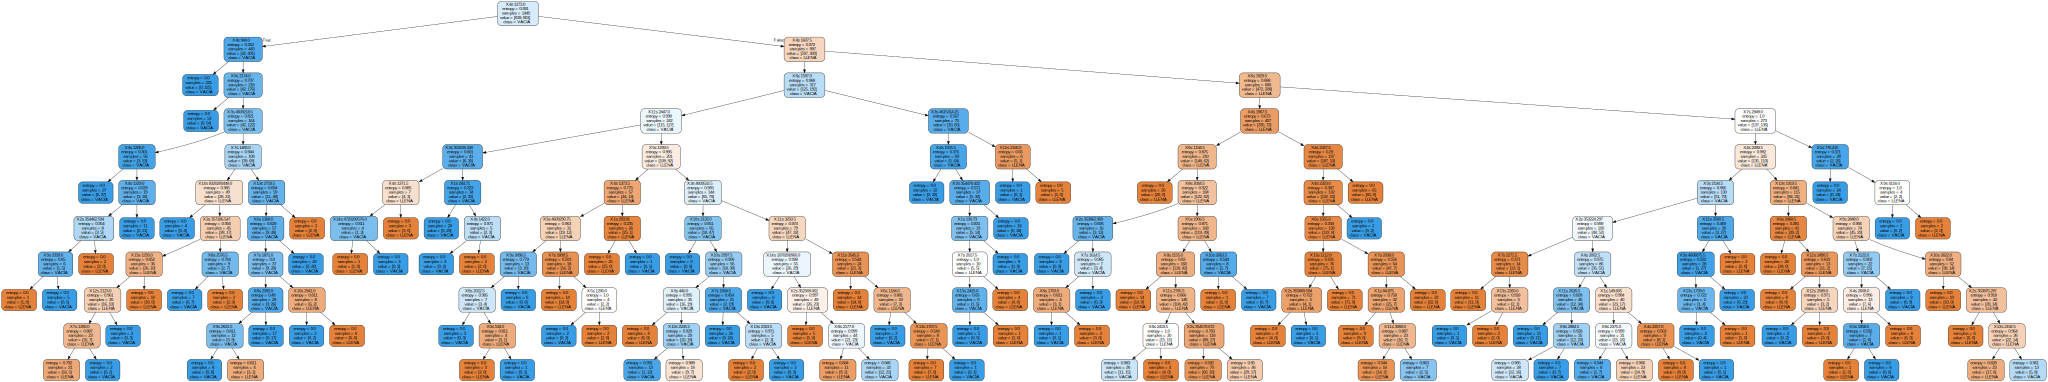

In [16]:
# Creo grafico con el diagrama del arbol de decision

# Configuro el grafico
dot_data = tree.export_graphviz(clf_AD, out_file=None, class_names=['LLENA','VACIA'], filled=True, 
                                rounded=True, special_characters=True) 

# Genero el grafico
graph = graphviz.Source(dot_data) 

# Salida del grafico
graph.render("Arbol Decision") # Grabo el arbol en un archivo pdf con el nombre especificado
graph # Lo represento en pantalla

In [17]:
# También puedo hacer un recuento del total de nodos y de los nodos finales
# que tiene el árbol utilizado, que nos dá una idea de su grado de complejidad.
# Se puede usar como pista para el diseño de futuras redes neuronales.

print("Numero de nodos del arbol: ", clf_AD.tree_.node_count)

# Utilizo matrices para almacenar la estructura de conexiones del arbol de decision
n_nodes = clf_AD.tree_.node_count
children_left = clf_AD.tree_.children_left
children_right = clf_AD.tree_.children_right

# Matrices para almacenar la profundidad de cada nodo y si es final
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)

# Semilla para el nodo inicial
stack = [(0, -1)]

# Variable para contar el numero de nodos finales
final_node = 0

# Bucle de comparacion que recorre cada nivel del arbol
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # Si el nodo es de test se incrementa el nivel
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    # Si no el nodo es final y se incrementa el contador
    else:
        is_leaves[node_id] = True
        final_node = final_node + 1

print("Nodos finales: ", final_node)

Numero de nodos del arbol:  217
Nodos finales:  109


#### Estudio las piscinas que acierta o falla este modelo 

Llevo una columna adicional de predicciones sobre el dataset original, repitiendo los filtros, para poderlo cargar en GIS y comprobar más fácilmente contra los datos.

In [18]:
# Añado las predicciones de este modelo en una nueva columna
Xy_test['Pred_ADSimple'] = y_pred

# Añado columna adicional con clasificacion de coincidencias
Xy_test['OK_ADSimple'] = Xy_test.Estado == Xy_test.Pred_ADSimple


# Muestro los datos
print ("Forma dataset: ", Xy_test.shape)
# Visualiza cabecera
print ("\nMuestra de datos:\n")
Xy_test.head()

Forma dataset:  (360, 18)

Muestra de datos:



,id,Area,X,Y,B02,B03,B04,B05,B06,B07,B08,B08A,B11,B12,id_img,Estado,Pred_ADSimple,OK_ADSimple
1760,696,374.42,357972.204,4611504.214,2460,1781,1601,1795,2807,3470,2483,3419,2051,1277,696_20200928,VACIA,LLENA,False
1404,569,95.69,353800.092,4608955.278,1469,1404,1254,2014,2580,2857,3091,3033,2941,2350,569_20200819,LLENA,VACIA,False
493,540,93.94,354413.460,4607785.128,1380,1154,1208,1637,2171,2593,2743,2437,2344,1965,540_20200327,VACIA,VACIA,True
414,304,72.47,354165.843,4607527.985,933,1198,1212,1753,2669,3196,3614,3229,2459,1660,304_20200327,VACIA,VACIA,True
199,558,109.20,353605.515,4608787.719,1580,1282,1292,1402,1975,2066,2104,2253,1585,1201,558_20200206,VACIA,VACIA,True


In [19]:
# Persisto el dataframe con las predicciones como csv para analizarlo posteriormente
Xy_test.to_csv('./DataRaster_csv/Xy_test_resultados.csv')

### Uso el alboritmo de embolsado adaptativo ADABOOST

Utiliza un conjunto de árboles de decisión de forma secuencial. Va asignando pesos crecientes a los datos incorrectamente clasificados, iterando el modelo en el conjunto de entrenamiento con los pesos actualizados. El modelo final es la suma ponderada de los resultados de los n algoritmos base. 

In [20]:
# Inicia cronometro
start_time = time.time()

# Defino un modelo ADA BOOST con base en el arbol de decision
clf_ADA = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = 'entropy',
                                                                     random_state = 0,
                                                                     max_depth=10,
                                                                     min_samples_split=3),
                             n_estimators=70, learning_rate=1, random_state=10)


# Modelo de entrenamiento
clf_ADA = clf_ADA.fit(X_train, y_train)

# Detiene el cronometro
end_time = time.time()

# Informo cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del ADA BOOST ha tardado: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred = clf_ADA.predict(X_test)

print('\nPrecision general de predicciones con ADA Boost')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, y_pred)))

print("Matriz de confusion para el conjunto de prueba:")
print(confusion_matrix(y_test, y_pred))

# Informo de rendimiento sobre el conjunto de prueba
print("\nInforme de rendimiento para el conjunto de prueba:\n")
print(classification_report(y_test, y_pred))


print('\nPrecisión modelo conjunto train: ', round(clf_ADA.score(X_train, y_train), 3))
print('Precisión modelo conjunto test: ', round(clf_ADA.score(X_test, y_test),3))


El entrenamiento del ADA BOOST ha tardado:  1.28 segundos ( 0.0 minutos)

Precision general de predicciones con ADA Boost
85.83%

Matriz de confusion para el conjunto de prueba:
[[139  21]
 [ 30 170]]

Informe de rendimiento para el conjunto de prueba:

              precision    recall  f1-score   support

       LLENA       0.82      0.87      0.84       160
       VACIA       0.89      0.85      0.87       200

    accuracy                           0.86       360
   macro avg       0.86      0.86      0.86       360
weighted avg       0.86      0.86      0.86       360


Precisión modelo conjunto train:  1.0
Precisión modelo conjunto test:  0.858


In [21]:
# Añado las predicciones de este modelo en una nueva columna
Xy_test['Pred_AdaBoostAD'] = y_pred

# Añado columna adicional con clasificacion de coincidencias
Xy_test['OK_AdaBoostAD'] = Xy_test.Estado == Xy_test.Pred_AdaBoostAD


# Muestro los datos
print ("Forma dataset: ", Xy_test.shape)
# Visualiza cabecera
print ("\nMuestra de datos:\n")
Xy_test.head()

Forma dataset:  (360, 20)

Muestra de datos:



,id,Area,X,Y,B02,B03,B04,B05,B06,B07,B08,B08A,B11,B12,id_img,Estado,Pred_ADSimple,OK_ADSimple,Pred_AdaBoostAD,OK_AdaBoostAD
1760,696,374.42,357972.204,4611504.214,2460,1781,1601,1795,2807,3470,2483,3419,2051,1277,696_20200928,VACIA,LLENA,False,LLENA,False
1404,569,95.69,353800.092,4608955.278,1469,1404,1254,2014,2580,2857,3091,3033,2941,2350,569_20200819,LLENA,VACIA,False,LLENA,True
493,540,93.94,354413.460,4607785.128,1380,1154,1208,1637,2171,2593,2743,2437,2344,1965,540_20200327,VACIA,VACIA,True,VACIA,True
414,304,72.47,354165.843,4607527.985,933,1198,1212,1753,2669,3196,3614,3229,2459,1660,304_20200327,VACIA,VACIA,True,VACIA,True
199,558,109.20,353605.515,4608787.719,1580,1282,1292,1402,1975,2066,2104,2253,1585,1201,558_20200206,VACIA,VACIA,True,VACIA,True


In [22]:
# Persisto el dataframe con las predicciones como csv para analizarlo posteriormente
Xy_test.to_csv('./DataRaster_csv/Xy_test_resultados.csv')